# 규제가 있는 선형회귀 - 릿지, 라쏘, 엘라스틱넷 회귀

#### 1. 준비

In [1]:
# 관련 라이브러리 및 모듈 Import
# import
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import SGDRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
def evaluate_score(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f'mse- {mse:.3f}')
    print(f'rmse- {rmse:.3f}')
    print(f'r2- {r2:.3f}')
    
    return

## 데이터 수집, 탐색, 준비

####  데이터셋에 대한 설명 및 정보 확인

In [4]:
# 데이터 csv 불러오기
train = pd.read_csv('./train5.csv')

In [5]:
# X(독립변수), Y(종속변수) 분할
X = train.drop('match', axis=1)
y = train['match']
# 학습용 데이터와 평가용 데이터로 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 모델별 계수변화, 알파별 계수 비교 데이터프레임(comp_df)

In [6]:
#각 모델별 계수로 이루어진 데이터프레임 준비
comp_df = pd.DataFrame(index=list(X.columns)+['R2_scores'])
comp_df

""
gender
attr_s
sinc_s
intel_s
fun_s
amb_s
attr_eval
sinc_eval
intel_eval
fun_eval


## 각 모델별, 규제강도별 평가지표 저장

####  데이터셋에 대한 설명 및 정보 확인

### 1. 규제가 없는 선형모델

In [7]:
#모델 구축 및 학습
model_LR = LinearRegression()
model_LR = model_LR.fit(X_train, y_train)

#모델 평가
y_pred = model_LR.predict(X_test)
y_pred[y_pred < 0] = 0.

r2 = r2_score(y_test, y_pred)
print(f"r2= {r2:3f}")
# 회귀 계수 확인
evaluate_score(y_test, y_pred)

# r2
LR_coef = pd.Series(model_LR.coef_, index=X.columns)
print(LR_coef)

r2= 0.192147
mse- 459.932
rmse- 21.446
r2- 0.192
gender        3.109983
attr_s        0.351262
sinc_s        0.354156
intel_s       0.436773
fun_s         0.759271
amb_s         0.464791
attr_eval     3.244837
sinc_eval     0.628047
intel_eval   -0.242355
fun_eval     -0.642997
amb_eval      0.348415
shar_eval     3.469598
like_eval     1.400890
dtype: float64


- 계수값 시각화

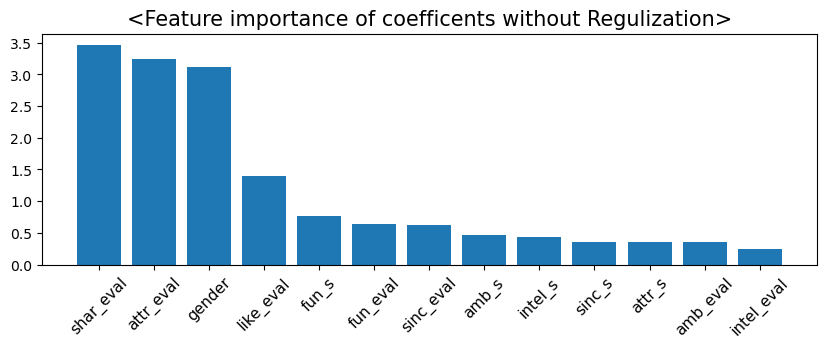

In [8]:
coef = LR_coef.sort_values(ascending=False)
coef = np.abs(LR_coef).sort_values(ascending=False)
# print('======')
# 시각화
plt.figure(figsize=(10,3))
plt.title('<Feature importance of coefficents without Regulization>', fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);

In [9]:
# 모델별 비교 데이터프레임 열 추가
comp_df["LR"] = np.append(model_LR.coef_, r2)
comp_df

,LR
gender,3.109983
attr_s,0.351262
sinc_s,0.354156
intel_s,0.436773
fun_s,0.759271
amb_s,0.464791
attr_eval,3.244837
sinc_eval,0.628047
intel_eval,-0.242355
fun_eval,-0.642997


### 1. 릿지 모델

In [10]:
# 데이터 csv 불러오기
train = pd.read_csv('./train5.csv')

In [11]:
# X(독립변수), Y(종속변수) 분할
X = train.drop('match', axis=1)
y = train['match']
# 학습용 데이터와 평가용 데이터로 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
from sklearn.linear_model import Ridge

model_Ridge = Ridge(alpha=1)
model_Ridge.fit(X_train, y_train)

Ridge(alpha=1)

In [13]:
# 릿지 선형회귀 모델 평가: model_Ridge1, alpha=1
y_pred = model_Ridge.predict(X_test)
y_pred[y_pred < 0] = 0.

r2 = r2_score(y_test, y_pred)
print(r2)
# a=1일때 회귀 계수 확인

Ridge_coef = pd.Series(model_Ridge.coef_, index=X.columns)
Ridge_coef

0.19225906800388903


gender        3.061553
attr_s        0.353049
sinc_s        0.355125
intel_s       0.436322
fun_s         0.756183
amb_s         0.465114
attr_eval     3.233222
sinc_eval     0.620181
intel_eval   -0.234433
fun_eval     -0.629774
amb_eval      0.354644
shar_eval     3.458852
like_eval     1.402310
dtype: float64

- 계수값 시각화

In [14]:
pd.Series(np.abs(Ridge_coef), index=X.columns)

gender        3.061553
attr_s        0.353049
sinc_s        0.355125
intel_s       0.436322
fun_s         0.756183
amb_s         0.465114
attr_eval     3.233222
sinc_eval     0.620181
intel_eval    0.234433
fun_eval      0.629774
amb_eval      0.354644
shar_eval     3.458852
like_eval     1.402310
dtype: float64

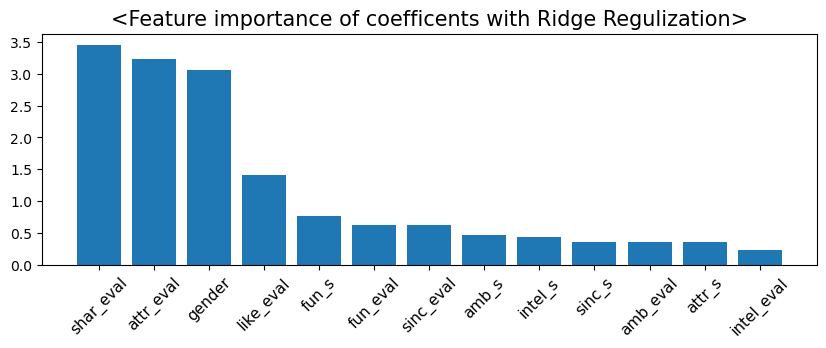

In [15]:
coef = pd.Series(np.abs(Ridge_coef), index=X.columns)
coef = coef.sort_values(ascending=False)
# 시각화
plt.figure(figsize=(10,3))
plt.title('<Feature importance of coefficents with Ridge Regulization>', fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);

In [16]:
# alpha_list=[0.01, 1, 10, 100]인 경우

alpha_list = [0.01, 0.1, 1.5, 10]

for each in alpha_list:
    model_Ridge = Ridge(alpha=each)
    model_Ridge.fit(X_train, y_train)
    
    y_pred = model_Ridge.predict(X_test)
    y_pred[y_pred < 0] = 0.
    
    r2 = r2_score(y_test, y_pred)
    col_name = f'Ridge(alpha={each:.2f})'
    
    comp_df[col_name] = np.append(model_Ridge.coef_, r2)

In [17]:
comp_df

,LR,Ridge(alpha=0.01),Ridge(alpha=0.10),Ridge(alpha=1.50),Ridge(alpha=10.00)
gender,3.109983,3.109492,3.105074,3.037880,2.683374
attr_s,0.351262,0.351280,0.351441,0.353941,0.368879
sinc_s,0.354156,0.354166,0.354254,0.355601,0.362914
intel_s,0.436773,0.436769,0.436730,0.436084,0.431085
fun_s,0.759271,0.759240,0.758958,0.754671,0.731791
amb_s,0.464791,0.464794,0.464824,0.465270,0.467455
attr_eval,3.244837,3.244720,3.243667,3.227482,3.136192
sinc_eval,0.628047,0.627967,0.627248,0.616350,0.560199
intel_eval,-0.242355,-0.242275,-0.241553,-0.230554,-0.171977
fun_eval,-0.642997,-0.642864,-0.641665,-0.623239,-0.519276


### 2. 라쏘 모델

In [18]:
from sklearn.linear_model import Lasso

# alpha=1인 경우(default)
model_Lasso = Lasso(alpha=1)
model_Lasso.fit(X_train, y_train)

Lasso(alpha=1)

In [19]:
# 라쏘 선형회귀 모델 평가(alpha=1)
# 선형 모델 평가
y_pred = model_Lasso.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)
#a = 1 라쏘 모델 회귀 계수
Lasso_coef = pd.Series(model_Lasso.coef_, index=X.columns)
Lasso_coef

0.1861940757515601


gender        0.000000
attr_s        0.225664
sinc_s        0.007883
intel_s       0.008596
fun_s         0.498251
amb_s         0.392542
attr_eval     2.916868
sinc_eval     0.000000
intel_eval    0.000000
fun_eval      0.000000
amb_eval      0.055450
shar_eval     3.385631
like_eval     0.796852
dtype: float64

- 계수 시각화

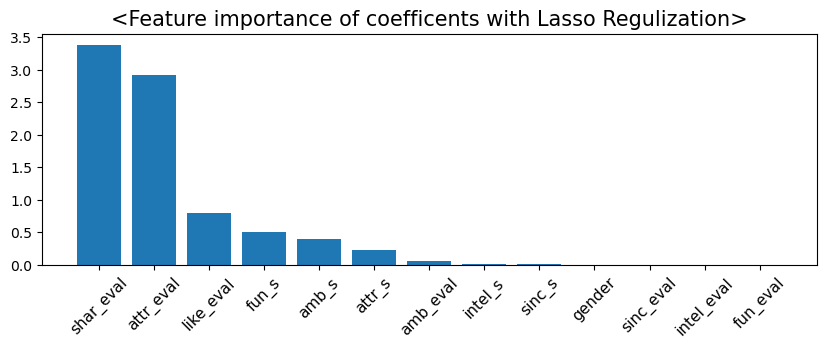

In [20]:
coef = np.abs(Lasso_coef)
coef = pd.Series(coef, index=X.columns).sort_values(ascending=False)
coef
# 시각화
plt.figure(figsize=(10,3))
plt.title('<Feature importance of coefficents with Lasso Regulization>', fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);

In [21]:
# alpha_list=[0.01, 1, 10, 100]인 경우

alpha_list = [0.01, 0.1, 1.5, 10]

for each in alpha_list:
    model_Lasso = Lasso(alpha=each)
    model_Lasso.fit(X_train, y_train)
    
    y_pred = model_Lasso.predict(X_test)
    y_pred[y_pred < 0] = 0.
    
    r2 = r2_score(y_test, y_pred)
    col_name = f'Lasso(alpha={each:.2f})'
    
    comp_df[col_name] = np.append(model_Lasso.coef_, r2)

In [22]:
comp_df

,LR,Ridge(alpha=0.01),Ridge(alpha=0.10),Ridge(alpha=1.50),Ridge(alpha=10.00),Lasso(alpha=0.01),Lasso(alpha=0.10),Lasso(alpha=1.50),Lasso(alpha=10.00)
gender,3.109983,3.109492,3.105074,3.037880,2.683374,3.056473,2.598948,0.000000,0.000000
attr_s,0.351262,0.351280,0.351441,0.353941,0.368879,0.350898,0.344913,0.099206,0.000000
sinc_s,0.354156,0.354166,0.354254,0.355601,0.362914,0.356621,0.354462,0.000000,0.000000
intel_s,0.436773,0.436769,0.436730,0.436084,0.431085,0.429463,0.395072,0.000000,0.000000
fun_s,0.759271,0.759240,0.758958,0.754671,0.731791,0.756419,0.711336,0.423789,0.000000
amb_s,0.464791,0.464794,0.464824,0.465270,0.467455,0.466125,0.459859,0.304020,0.000000
attr_eval,3.244837,3.244720,3.243667,3.227482,3.136192,3.235655,3.161252,2.876748,0.000000
sinc_eval,0.628047,0.627967,0.627248,0.616350,0.560199,0.589140,0.408750,0.000000,0.000000
intel_eval,-0.242355,-0.242275,-0.241553,-0.230554,-0.171977,-0.177863,0.000000,0.000000,0.000000
fun_eval,-0.642997,-0.642864,-0.641665,-0.623239,-0.519276,-0.605878,-0.287668,0.000000,0.000000


### 3. 엘라스틱넷 모델

In [23]:
from sklearn.linear_model import ElasticNet
# 모델 구축 및 학습(alpha=1, l1_ratio=0.5)

model_ElasticNet = ElasticNet(alpha=0.1, l1_ratio=0.5)
model_ElasticNet.fit(X_train, y_train)

ElasticNet(alpha=0.1)

In [24]:
#모델 평가 및 회귀 계수 확인
# 엘라스틱넷 선형회귀 모델 평가(alpha=0.1, L1_ratio=0.5)
# 선형 모델 평가
y_pred = model_ElasticNet.predict(X_test)
y_pred[y_pred < 0] = 0.

r2 = r2_score(y_test, y_pred)
print(r2)
evaluate_score(y_test, y_pred)
#a = 1 엘라스틱넷 모델 회귀 계수
ElasticNet_coef = pd.Series(model_ElasticNet.coef_, index=X.columns)

0.19455121041548995
mse- 458.563
rmse- 21.414
r2- 0.195


- 계수 시각화

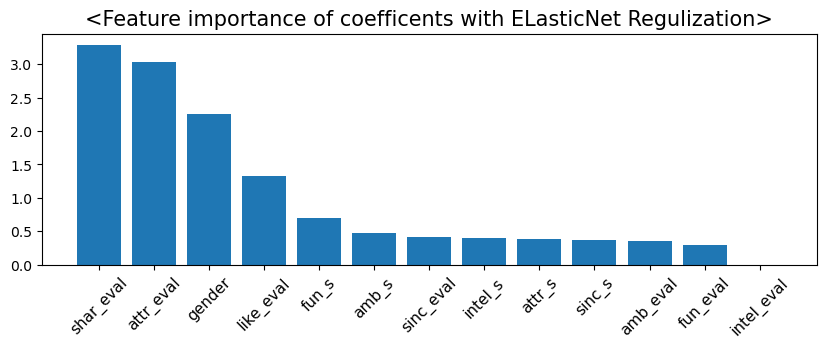

In [25]:
coef = np.abs(ElasticNet_coef)
coef = pd.Series(coef, index=X.columns).sort_values(ascending=False)
coef
# 시각화
plt.figure(figsize=(10,3))
plt.title('<Feature importance of coefficents with ELasticNet Regulization>', fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);

In [26]:
# alpha_list=[0.01, 1, 10, 100]인 경우, l1_ratio=0.5 

alpha_list = [0.01, 0.1, 1.5, 10]

for each in alpha_list:
    model_ElasticNet = ElasticNet(alpha=each)
    model_ElasticNet.fit(X_train, y_train)
    
    y_pred = model_ElasticNet.predict(X_test)
    y_pred[y_pred < 0] = 0.
    
    r2 = r2_score(y_test, y_pred)
    col_name = f'ElasticNet(alpha={each:.2f})'
    
    comp_df[col_name] = np.append(model_ElasticNet.coef_, r2)
comp_df

,LR,Ridge(alpha=0.01),Ridge(alpha=0.10),Ridge(alpha=1.50),Ridge(alpha=10.00),Lasso(alpha=0.01),Lasso(alpha=0.10),Lasso(alpha=1.50),Lasso(alpha=10.00),ElasticNet(alpha=0.01),ElasticNet(alpha=0.10),ElasticNet(alpha=1.50),ElasticNet(alpha=10.00)
gender,3.109983,3.109492,3.105074,3.037880,2.683374,3.056473,2.598948,0.000000,0.000000,3.004526,2.253265,0.000000,0.000000
attr_s,0.351262,0.351280,0.351441,0.353941,0.368879,0.350898,0.344913,0.099206,0.000000,0.354035,0.377025,0.437782,0.000000
sinc_s,0.354156,0.354166,0.354254,0.355601,0.362914,0.356621,0.354462,0.000000,0.000000,0.356906,0.367568,0.153446,0.000000
intel_s,0.436773,0.436769,0.436730,0.436084,0.431085,0.429463,0.395072,0.000000,0.000000,0.432398,0.402451,0.036650,0.000000
fun_s,0.759271,0.759240,0.758958,0.754671,0.731791,0.756419,0.711336,0.423789,0.000000,0.752802,0.698438,0.505341,0.000000
amb_s,0.464791,0.464794,0.464824,0.465270,0.467455,0.466125,0.459859,0.304020,0.000000,0.465948,0.467060,0.366303,0.000000
attr_eval,3.244837,3.244720,3.243667,3.227482,3.136192,3.235655,3.161252,2.876748,0.000000,3.221164,3.034134,2.011815,0.633499
sinc_eval,0.628047,0.627967,0.627248,0.616350,0.560199,0.589140,0.408750,0.000000,0.000000,0.596220,0.419298,0.132615,0.000000
intel_eval,-0.242355,-0.242275,-0.241553,-0.230554,-0.171977,-0.177863,0.000000,0.000000,0.000000,-0.197991,-0.000000,0.000000,0.000000
fun_eval,-0.642997,-0.642864,-0.641665,-0.623239,-0.519276,-0.605878,-0.287668,0.000000,0.000000,-0.603015,-0.289784,0.429491,0.234889


In [27]:
comp_df.loc['R2_scores'].sort_values()

Lasso(alpha=10.00)         0.041190
ElasticNet(alpha=10.00)    0.089062
Lasso(alpha=1.50)          0.187298
ElasticNet(alpha=1.50)     0.189143
LR                         0.192147
Ridge(alpha=0.01)          0.192148
Ridge(alpha=0.10)          0.192158
Ridge(alpha=1.50)          0.192314
Lasso(alpha=0.01)          0.192473
ElasticNet(alpha=0.01)     0.192489
Ridge(alpha=10.00)         0.193116
Lasso(alpha=0.10)          0.194250
ElasticNet(alpha=0.10)     0.194551
Name: R2_scores, dtype: float64